<center> <h2>Gaussian Process Species Distribution Modeling with Physiological Priors</h2>
Skip to the [results](#Now-we-create-the-gaussian-random-field-model.)


In [2]:
library(dismo)  #see also zoon R package?
library(plyr)
library(rgbif)
library(GRaF)  #see methods paper here: http://onlinelibrary.wiley.com/doi/10.1111/2041-210X.12523/pdf
library(pROC)
library(ROCR)
devtools::install_github("ropenscilabs/rgeospatialquality")

 
#for cleaning data
library(biogeo) #https://cran.r-project.org/web/packages/biogeo/index.html
library(rgeospatialquality) #https://cran.r-project.org/web/packages/rgeospatialquality/

Loading required package: raster
Loading required package: sp
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Skipping install of 'rgeospatialquality' from a github remote, the SHA1 (47c416eb) has not changed since last install.
  Use `force = TRUE` to force installation

Attaching package: ‘biogeo’

The following object is masked _by_ ‘.GlobalEnv’:

    dat



In [3]:
setwd("~/Dropbox/Projects/UW/SDMpriors/")

__ We have a file `Sundayetal_thermallimits.csv` which contains CTmin and CTmax for a variety of species. We'll work with that data to build physiological priors. __

In [4]:
phys = read.csv("Sundayetal_thermallimits.csv")
phys = subset(phys, phys$phylum=="Chordata")
phys= phys[!is.na(phys$tmax) & !is.na(phys$tmin),]
phys$spec = gsub("_", " ", phys$species)
head(phys)


,species,tmax,tmin,tmax_metric,tmin_metric,lat,longitude,hemisphere,altitude,phylum,class,order,family,genus,sim_altitude,Ref.,spec
71,Bufo_alvarius,39.9,2.5,crit,leth,31.00,-112.00,N,304.8,Chordata,Amphibia,Anura,Bufonidae,Bufo,553,Brattstrom_1968,Bufo alvarius
73,Bufo_canaliferus,37.3,9.5,crit,leth,14.58,-90.53,N,914.4,Chordata,Amphibia,Anura,Bufonidae,Bufo,1617,Brattstrom_1968,Bufo canaliferus
74,Bufo_canorus,38.0,-2.0,crit,leth,37.91,-119.26,N,2743.2,Chordata,Amphibia,Anura,Bufonidae,Bufo,3145,Brattstrom_1968,Bufo canorus
76,Bufo_cognatus,41.3,-4.0,crit,leth,31.00,-112.00,N,304.8,Chordata,Amphibia,Anura,Bufonidae,Bufo,553,Brattstrom_1968,Bufo cognatus
77,Bufo_debilis,40.1,2.5,crit,leth,27.00,-112.00,N,304.8,Chordata,Amphibia,Anura,Bufonidae,Bufo,82,Brattstrom_1968,Bufo debilis
78,Bufo_exsul,37.1,-4.0,crit,leth,38.06,-84.45,N,1524.0,Chordata,Amphibia,Anura,Bufonidae,Bufo,291,Brattstrom_1968,Bufo exsul


**For this experiment, we'll focus on _Sceloporus occidentalis_.**

In [5]:
speciesKey = 55 # (Sceloporus occidentalis)

**Occurrence data comes from GBIF**


Attaching package: ‘maps’

The following object is masked from ‘package:plyr’:

    ozone

Rendering map...plotting 989 points


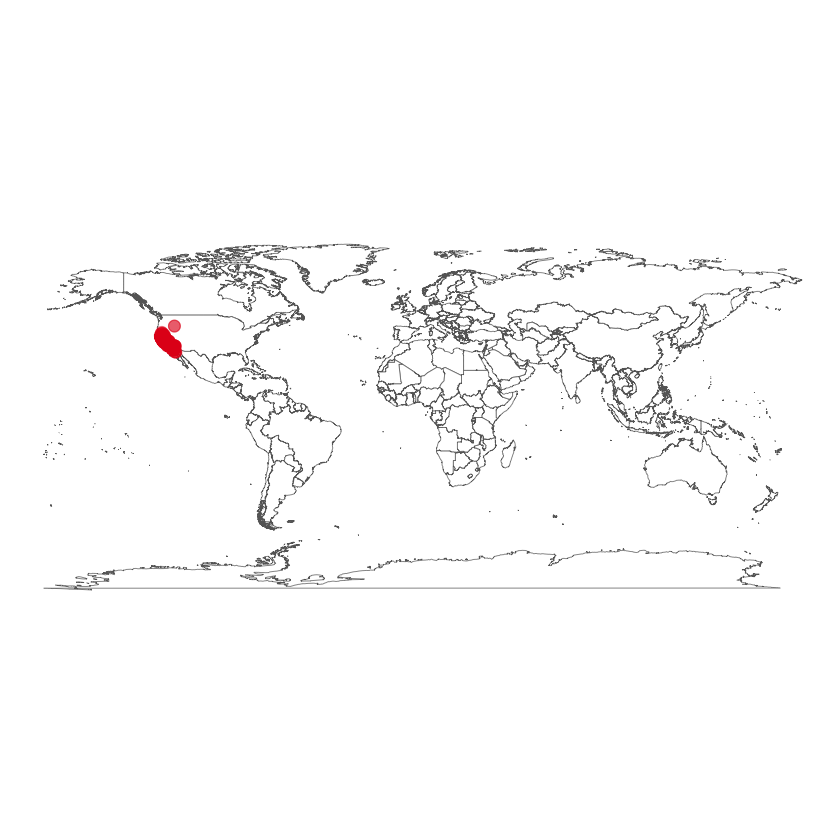

In [6]:
gbifKey = name_suggest(q=phys$spec[speciesKey], rank='species')$key[1]
occs = occ_data(scientificName = phys$spec[speciesKey], limit=1000, minimal=TRUE)$data
gbifmap(occs)

In [7]:
occs = occs[which(!is.na(occs$"decimalLongitude") & !is.na(occs$"decimalLatitude")),]

In [8]:
nrow(occs)

[1] 990

**We can then define absence points by sampling within a range of observed presence points **

In [9]:
bufs = circles(occs[,c("decimalLongitude", "decimalLatitude")], d=50000, lonlat=TRUE)

In [10]:
abs  = spsample(bufs@polygons, 100, type='random', iter=100)

** We get climate data for the extent of observed points **

In [11]:
BClim = getData("worldclim", var='bio', res=2.5)

In [12]:
ext = extent(rbind(range(occs$decimalLongitude), range(occs$decimalLatitude)))
BClim = crop(BClim, ext)

In [13]:
clim_Pres = extract(BClim, occs[,c("decimalLongitude", "decimalLatitude")])
clim_Pres = data.frame(lon=occs$decimalLongitude,
                       lat=occs$decimalLatitude,
                       clim_Pres)
head(clim_Pres)

lon,lat,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,⋯,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
-118.3144,33.73874,175,100,52,3176,275,84,191,140,⋯,219,139,345,73,0,93,193,4,9,193
-118.3155,33.73856,175,100,52,3176,275,84,191,140,⋯,219,139,345,73,0,93,193,4,9,193
-122.0371,37.82916,145,123,51,4299,279,38,241,91,⋯,201,91,556,113,1,85,288,7,11,288
-118.3829,33.80051,175,100,53,3034,271,85,186,141,⋯,217,140,338,74,0,94,195,3,9,191
-118.4061,33.74694,174,97,53,3011,269,87,182,141,⋯,216,140,329,71,0,93,186,3,9,185
-121.9579,37.43620,153,117,53,3846,268,48,220,112,⋯,200,102,344,71,1,85,178,5,8,178


In [175]:
clim_Abs  = extract(BClim, abs)
clim_Abs  = data.frame(lon=abs@coords[,'x'], lat=abs@coords[,'y'], clim_Abs)
head(clim_Abs)

lon,lat,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,⋯,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
-116.7940,31.85656,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-119.1577,35.83257,177,156,44,6929,371,21,350,108,⋯,265,89,213,37,0,79,111,3,3,101
-122.0996,40.31887,168,143,42,6941,363,24,339,88,⋯,258,84,730,131,4,74,355,26,26,348
-123.5745,39.06474,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
-121.0634,38.07720,160,146,46,5984,342,29,313,83,⋯,234,83,406,77,1,82,203,6,6,203
-118.9706,34.57704,134,122,43,5662,294,15,279,74,⋯,212,70,491,94,1,89,267,6,15,258


** We can then combine the presence and absence data into a single dataframe with an additional column representing whether the point is a presence or an absence **

In [211]:
presence = rep(1,dim(clim_Pres)[1])
presence_temp = data.frame(presence, clim_Pres)
presence = rep(0, dim(clim_Abs)[1])
absence_temp = data.frame(presence, clim_Abs)
print(colnames(presence_temp))
print(colnames(absence_temp))
clim_PresAbs = rbind(presence_temp, absence_temp)
clim_PresAbs = na.omit(clim_PresAbs)

 [1] "presence" "lon"      "lat"      "bio1"     "bio2"     "bio3"    
 [7] "bio4"     "bio5"     "bio6"     "bio7"     "bio8"     "bio9"    
[13] "bio10"    "bio11"    "bio12"    "bio13"    "bio14"    "bio15"   
[19] "bio16"    "bio17"    "bio18"    "bio19"   
 [1] "presence" "lon"      "lat"      "bio1"     "bio2"     "bio3"    
 [7] "bio4"     "bio5"     "bio6"     "bio7"     "bio8"     "bio9"    
[13] "bio10"    "bio11"    "bio12"    "bio13"    "bio14"    "bio15"   
[19] "bio16"    "bio17"    "bio18"    "bio19"   


In [212]:
clim_PresAbs

,presence,lon,lat,bio1,bio2,bio3,bio4,bio5,bio6,bio7,⋯,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
1,1,-118.3144,33.73874,175,100,52,3176,275,84,191,⋯,219,139,345,73,0,93,193,4,9,193
2,1,-118.3155,33.73856,175,100,52,3176,275,84,191,⋯,219,139,345,73,0,93,193,4,9,193
3,1,-122.0371,37.82916,145,123,51,4299,279,38,241,⋯,201,91,556,113,1,85,288,7,11,288
4,1,-118.3829,33.80051,175,100,53,3034,271,85,186,⋯,217,140,338,74,0,94,195,3,9,191
5,1,-118.4061,33.74694,174,97,53,3011,269,87,182,⋯,216,140,329,71,0,93,186,3,9,185
6,1,-121.9579,37.43620,153,117,53,3846,268,48,220,⋯,200,102,344,71,1,85,178,5,8,178
8,1,-122.1649,38.12473,147,124,51,4279,276,37,239,⋯,199,91,604,134,1,89,331,7,11,331
9,1,-117.8940,34.01010,179,145,55,4062,318,55,263,⋯,235,130,439,90,1,91,255,7,16,238
10,1,-118.3465,34.17915,177,128,53,3860,303,63,240,⋯,231,132,363,82,0,92,212,5,12,204
11,1,-117.1245,32.57378,169,94,51,2974,254,73,181,⋯,210,132,213,42,0,87,118,3,6,107


** Now we extract the variables we're interested in . **

In [213]:
climVars = c("presence", "bio1", "bio5", "bio6")
covs = clim_PresAbs[, climVars]

In [214]:
covs[,2:ncol(covs)] = covs[,2:ncol(covs)]/10
covs = na.omit(covs)
nrow(covs)

[1] 1054

We then select 75% of these data to be the training data, and 25% for the test data. 

In [215]:
set.seed(123)
train_size = floor(0.75*nrow(covs))
train_idxs = sample(seq_len(nrow(covs)), size=train_size)

trainData = covs[train_idxs,]
trainPres = trainData[,1]
trainCovs = trainData[,2:ncol(trainData)]
testData  = covs[-train_idxs,]
testPres = testData[,1]
testCovs = testData[,2:ncol(trainData)]




In [181]:
assertthat::are_equal(nrow(trainData)+nrow(testData), nrow(covs))

[1] TRUE

## Now we create the gaussian random field model.

**Models**:
* [Simple](#Simple-Model)
* [Simple with Lengthscale Optimisation](#Simple-With-Lengthscale-Optimisation)
* [Linear Prior Model](#Simple-With-Lengthscale-Optimisation)

### Simple Model

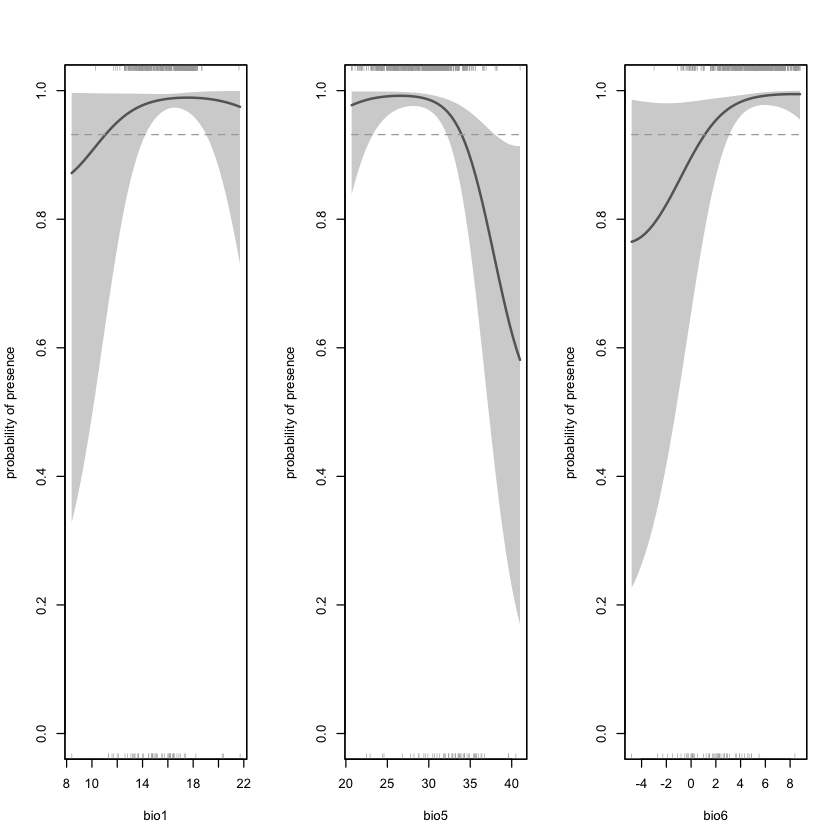

In [182]:
simple = graf(trainPres, trainCovs)
par(mfrow = c(1,3))
plot(simple, prior=T)

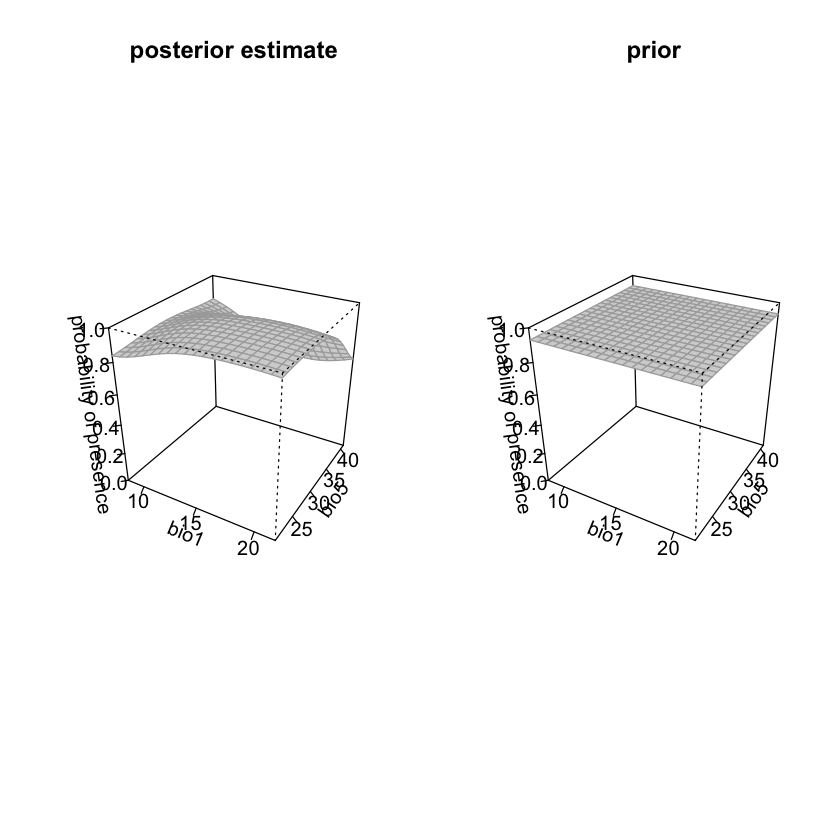

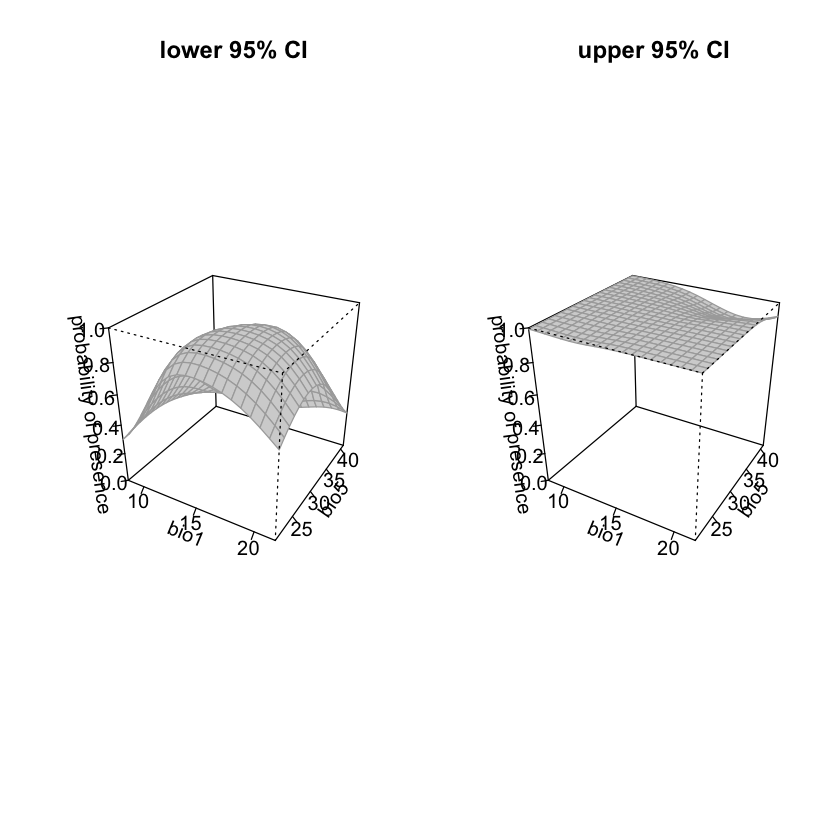

In [22]:
par(mfrow=c(1,2), mfcol=c(1,2))
plot3d(simple)

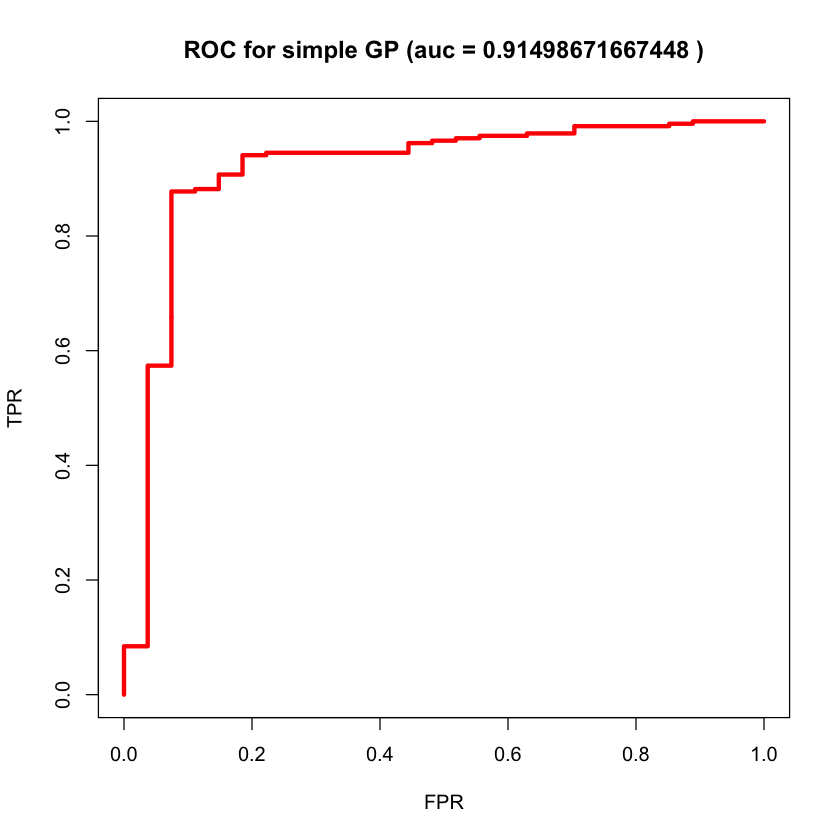

In [23]:
csimplePred = data.frame(predict(simple, testCovs))
prob = csimplePred$posterior.mode
pred = prediction(prob, testPres)
perf = performance(pred, measure='tpr', x.measure='fpr')
auc  = performance(pred, measure='auc')
auc = auc@y.values[[1]]
roc.data <- data.frame(fpr=unlist(perf@x.values),
                       tpr=unlist(perf@y.values),
                       model="GP")
plot(roc.data$fpr,roc.data$tpr,type="l",col="red",ylab="TPR",xlab="FPR",main= paste("ROC for simple GP (auc =", auc, ")"),lwd=3.5)
p = recordPlot()


In [24]:
auc(testPres, prob)


Area under the curve: 0.915

Pretty great. Next we'll optimize the lengthscales of the Gaussian Process kernels and see if we can't do better. 

### Simple With Lengthscale Optimisation

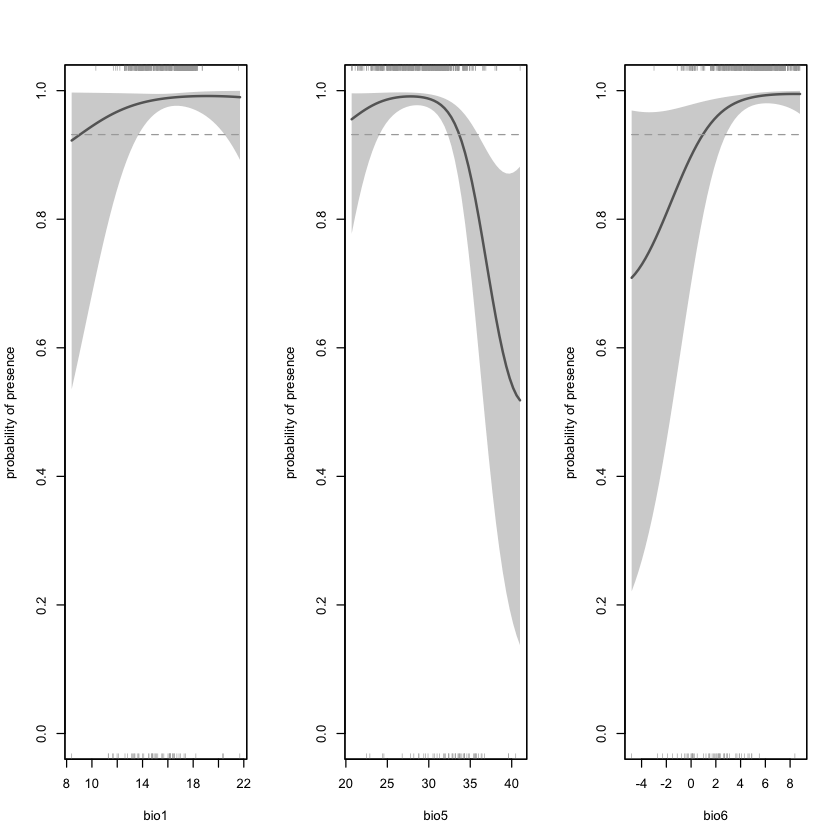

In [25]:
simple_lengthscale = graf(trainPres, trainCovs, opt.l=T)
par(mfrow = c(1,3))
plot(simple_lengthscale, prior=T)

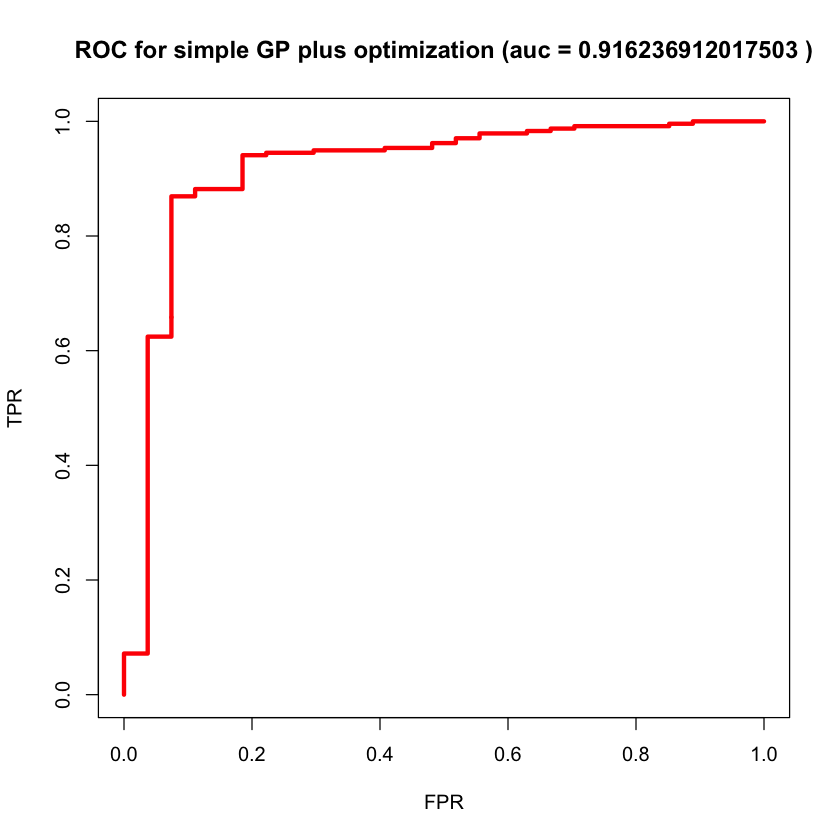

In [26]:
csimplePred = data.frame(predict(simple_lengthscale, testCovs))
prob = csimplePred$posterior.mode
pred = prediction(prob, testPres)
perf = performance(pred, measure='tpr', x.measure='fpr')
auc  = performance(pred, measure='auc')
auc = auc@y.values[[1]]
roc.data <- data.frame(fpr=unlist(perf@x.values),
                       tpr=unlist(perf@y.values),
                       model="GP")
plot(roc.data$fpr,roc.data$tpr,type="l",col="red",ylab="TPR",xlab="FPR",
     main=paste("ROC for simple GP plus optimization (auc =", auc, ")"),lwd=3.5)



In [27]:
auc(testPres, prob)

Area under the curve: 0.9162

A little worse, in terms of ROC. We can build a **linear model** as a prior: 

### Linear Prior Model

In [28]:
m.lin = glm(trainPres ~ bio1, data=trainCovs, family = binomial)
linPredict = function(covs) predict(m.lin, covs, type='response')

In [29]:
linearGP = graf(trainPres, trainCovs, opt.l = T, prior = linPredict)

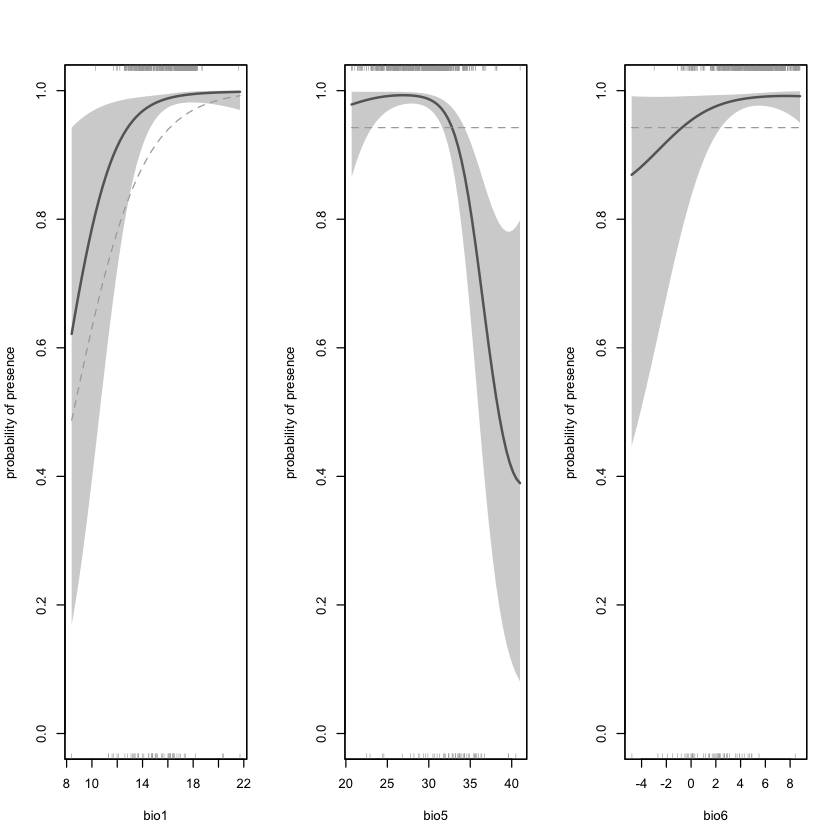

In [30]:
par(mfrow = c(1,3))
plot(linearGP, prior=T)


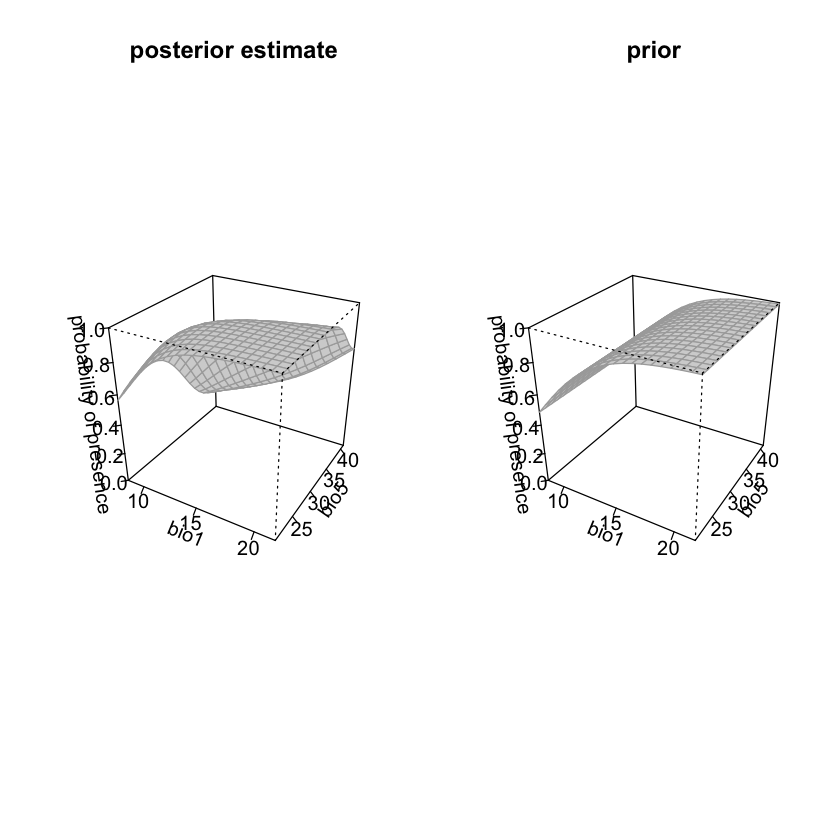

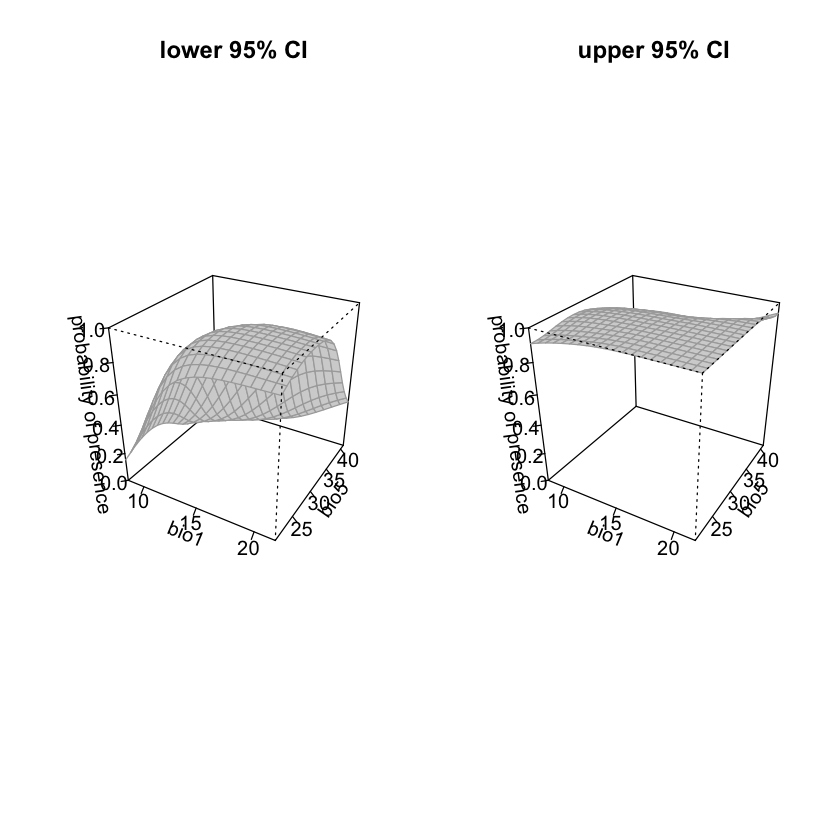

In [31]:
par(mfrow=c(1,2), mfcol=c(1,2))
plot3d(linearGP)

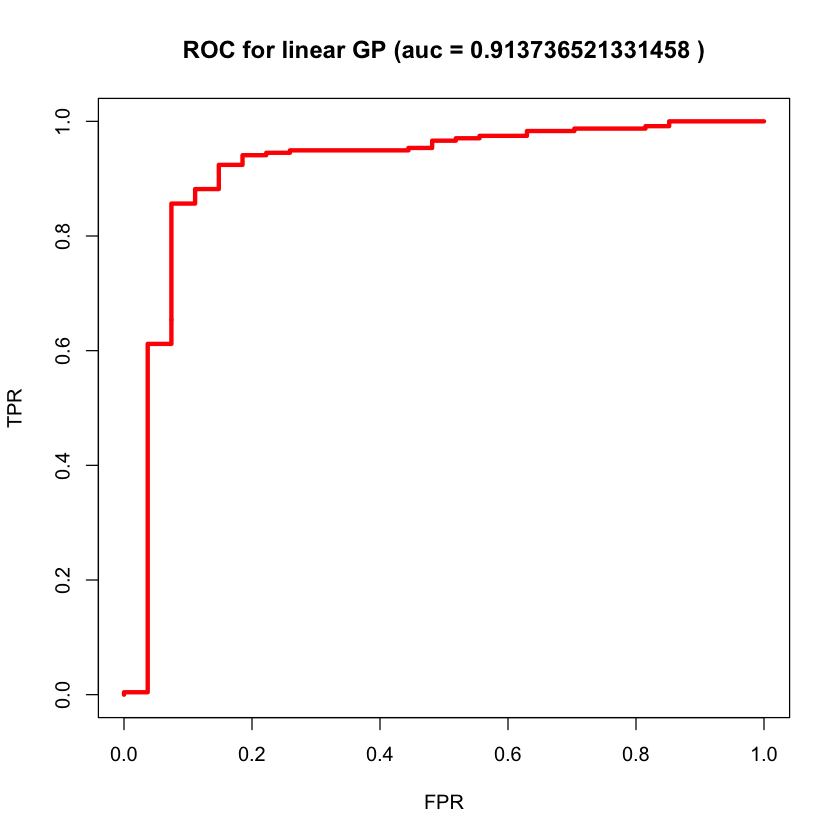

In [32]:
csimplePred = data.frame(predict(linearGP, testCovs))
prob = csimplePred$posterior.mode
pred = prediction(prob, testPres)
perf = performance(pred, measure='tpr', x.measure='fpr')
auc  = performance(pred, measure='auc')
auc = auc@y.values[[1]]
roc.data <- data.frame(fpr=unlist(perf@x.values),
                       tpr=unlist(perf@y.values),
                       model="GP")
plot(roc.data$fpr,roc.data$tpr,type="l",col="red",ylab="TPR",xlab="FPR",
     main=paste("ROC for linear GP (auc =", auc,")"),lwd=3.5)
p = recordPlot()

In [33]:
auc(testPres, prob)

Area under the curve: 0.9137

Better! Now we'll spend some time on a prior leveraging multiple environmental covariates and exponential probability distributions on physiological tolerance thresholds. 

In [34]:
#e.max <- function(x) ifelse(x<phys$tmax[speciesKey]-10, 0.9, exp(-(x-phys$tmax[speciesKey]+10)/5)) #max  
#e.min <- function(x) ifelse(x<phys$tmin[speciesKey]   , 0.1, 1- exp(-(x-(phys$tmax[speciesKey])/10000) ) ) #min fix

e.max<-function(x) ifelse(x<phys$tmax[speciesKey]-10, 0.9, exp(-(x-phys$tmax[speciesKey]+10)/5)) #max  
e.min<-function(x) ifelse(x<phys$tmin[speciesKey]   , 0.1, 1- exp(-(x-(phys$tmax[speciesKey])/10000) ) ) #min fix
                            

#bio1: mean, bio5:max, bio6:min (THIS IS A BAD PRIOR -- FOR TESTING)
e.prior = function(x) e.max(x[,2]) * e.min(x[,3])


In [35]:
e.prior= function(x) e.max(x[,2]) * e.min(x[,3])
length(e.max(trainCovs[,2]) * e.min(trainCovs[,3]))

[1] 790

In [36]:
eModel = graf(trainPres, trainCovs, prior = e.prior, opt.l=T)

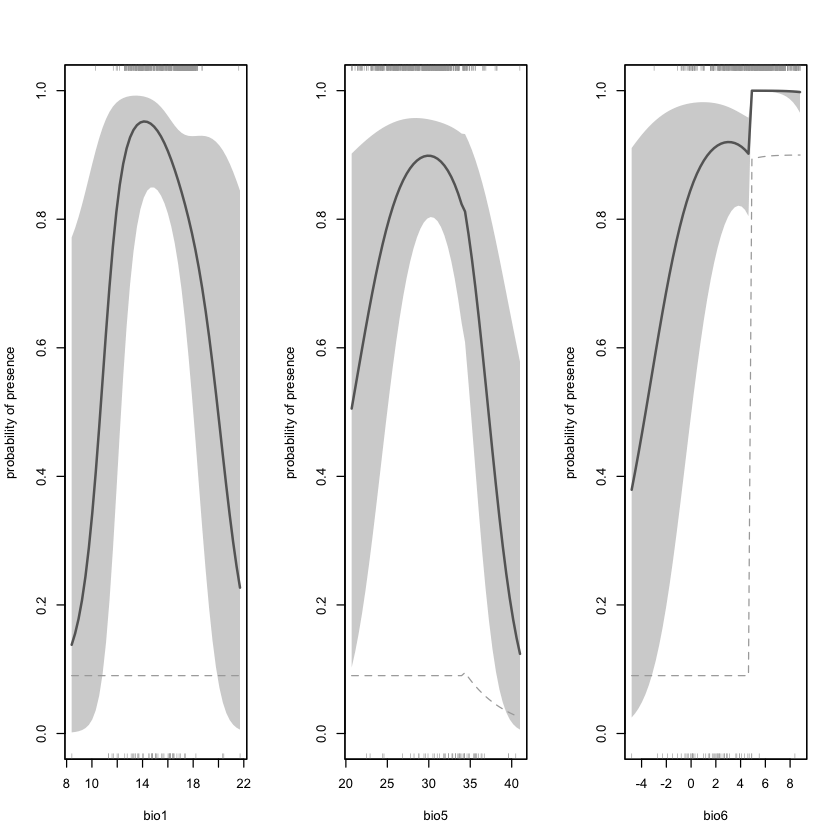

In [37]:
par(mfrow = c(1,3))
plot(eModel, prior=T)


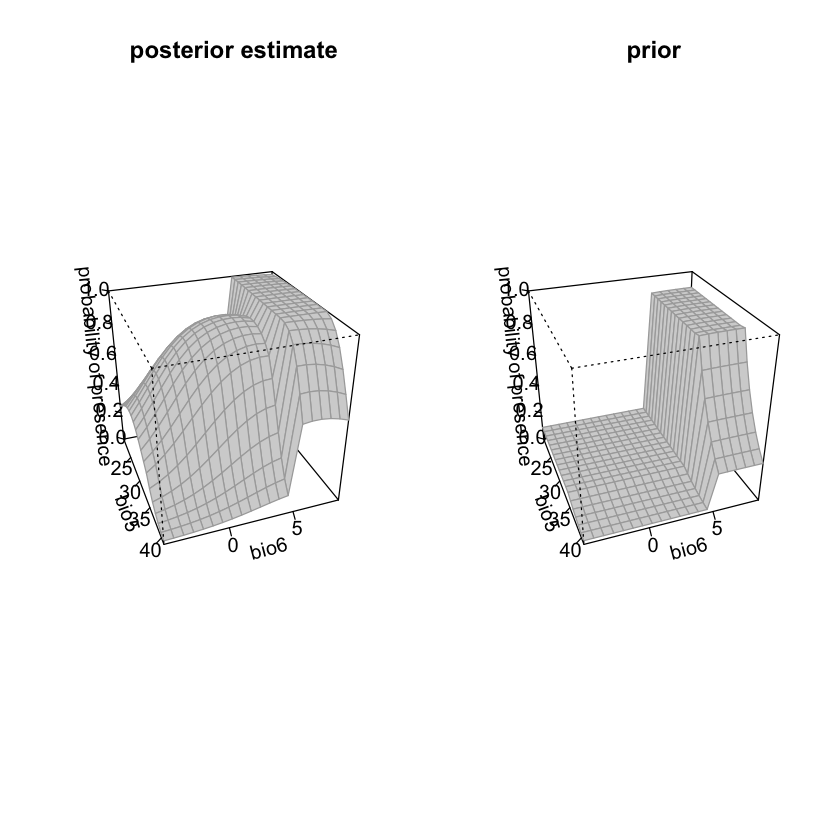

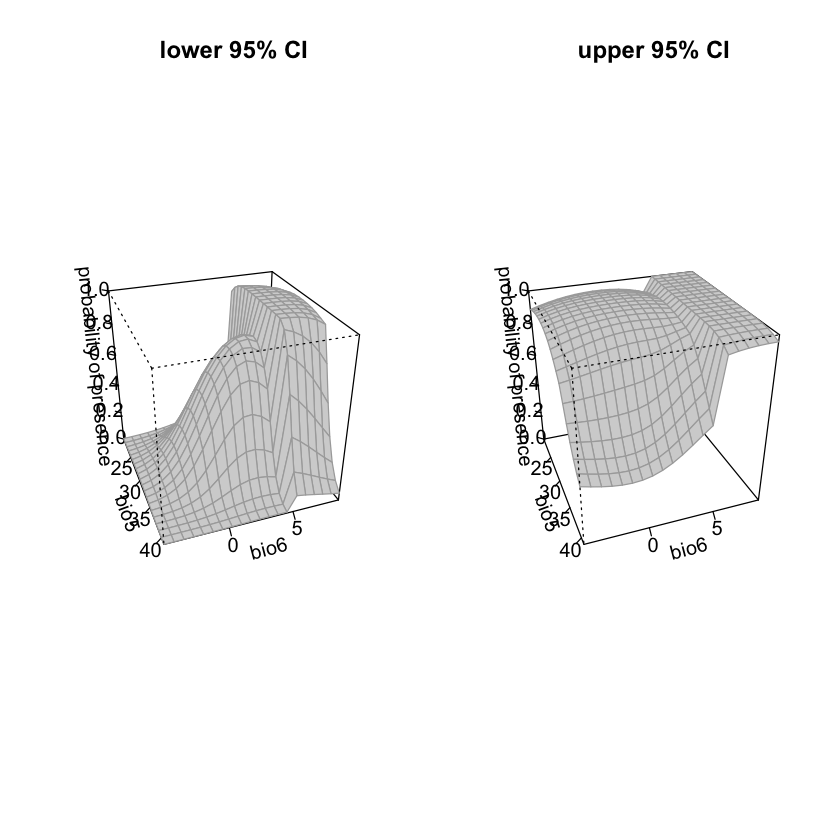

In [38]:
par(mfrow=c(1,2), mfcol=c(1,2))
plot3d(eModel, theta=70, dims=c(2,3))

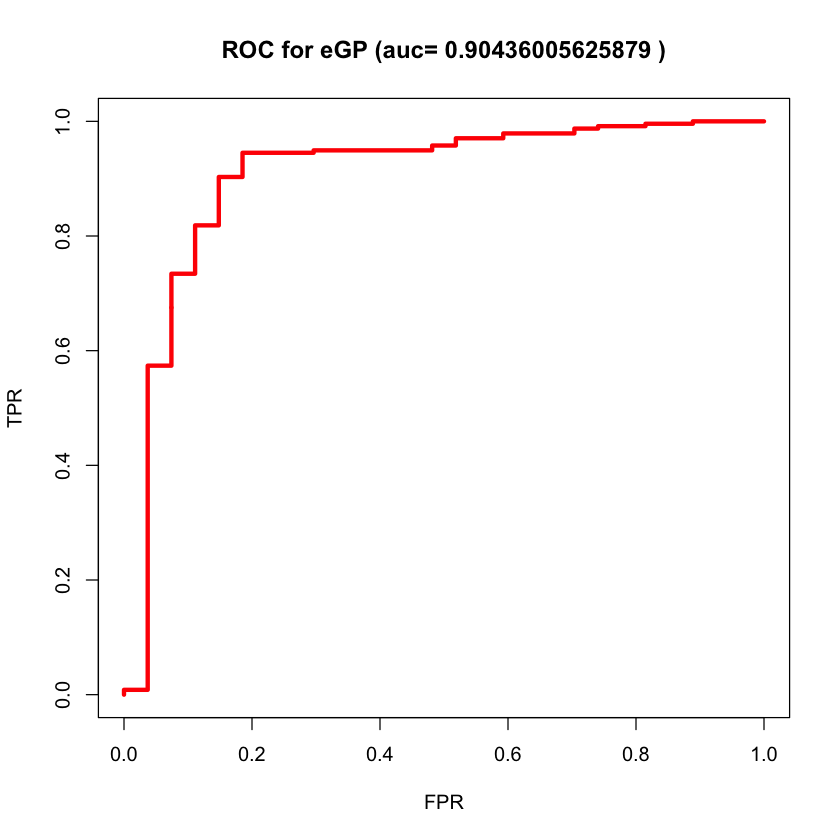

In [39]:
csimplePred = data.frame(predict(eModel, testCovs))
prob = csimplePred$posterior.mode
pred = prediction(prob, testPres)
perf = performance(pred, measure='tpr', x.measure='fpr')
auc  = performance(pred, measure='auc')
auc = auc@y.values[[1]]
roc.data <- data.frame(fpr=unlist(perf@x.values),
                       tpr=unlist(perf@y.values),
                       model="GP")
plot(roc.data$fpr,roc.data$tpr,type="l",col="red",ylab="TPR",xlab="FPR",main=paste("ROC for eGP (auc=",auc,")"),lwd=3.5)
p = recordPlot()

In [40]:
auc(testPres, prob)

Area under the curve: 0.9044

Best Yet!

In [41]:
write.csv(cbind(testPres, testCovs), "test_data_scleroporus.csv")
write.csv(cbind(trainPres, trainCovs), "train_data_scleroporus.csv")


---

Designing a new prior: we create a normal distribution between the CTmin and CTmax with the mean = CTmax-CTMin and the SD = mean/2.

In [159]:
ct.mean = phys$tmax[speciesKey] - phys$tmin[speciesKey]
ct.std  = ct.mean / 2
ct.thresh <- function(x) ifelse(x$bio6 > phys$tmin[speciesKey] & x$bio5 < dat$tmax[spec.k], 1, .00001)
ct.prob = function(x) {
    dnorm(x$bio1, mean=ct.mean, sd = ct.std) * ct.thresh(x)
}
ct.cumprob = function(x){
    ct.thresh(x) * (pnorm(x$bio5, mean=ct.mean, sd=ct.std) - pnorm(x$bio6, mean=ct.mean, sd=ct.std))
}

In [150]:
ct.model = graf(trainPres, trainCovs, prior = ct.prob, opt.l = T)

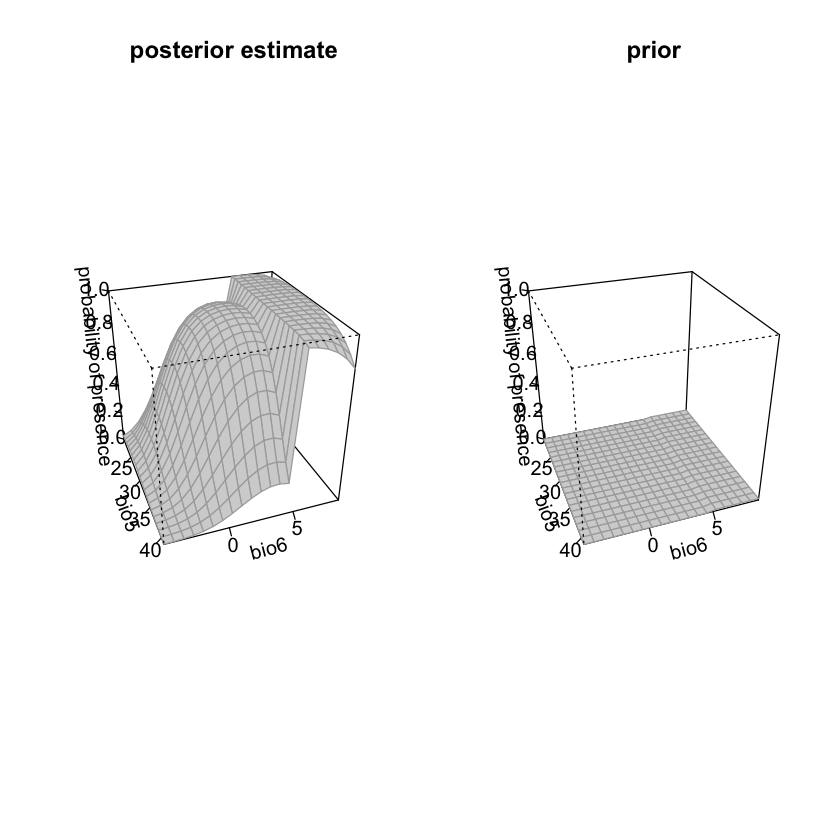

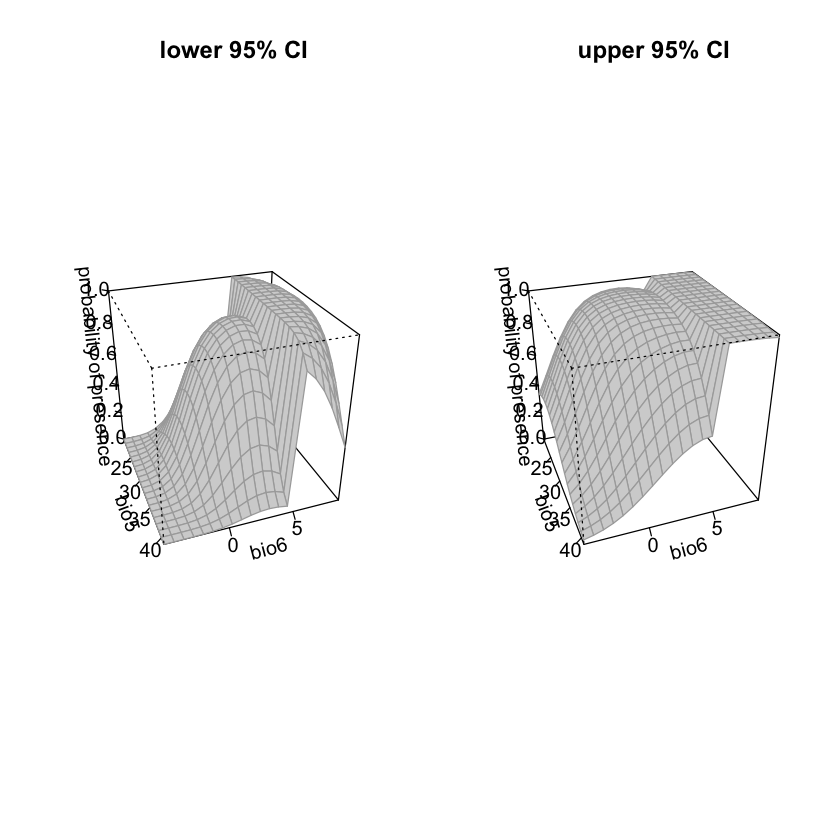

In [151]:
par(mfrow=c(1,2), mfcol=c(1,2))
plot3d(ct.model, theta=70, dims=c(2,3))

In [133]:
thresh(covs[1:4,])

[1] TRUE

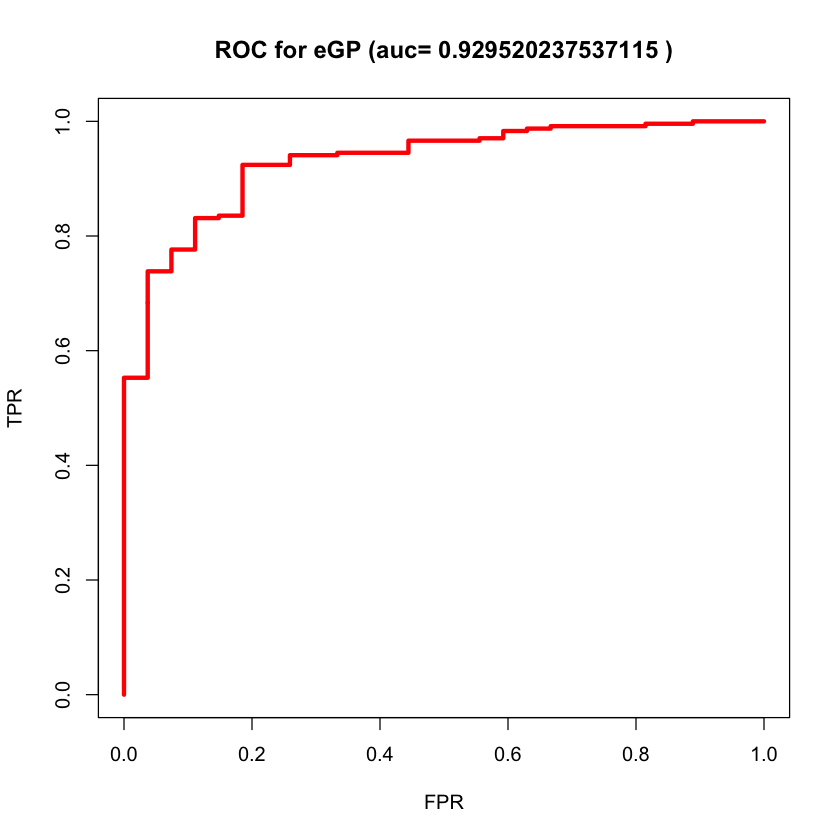

In [152]:
csimplePred = data.frame(predict(ct.model, testCovs))
prob = csimplePred$posterior.mode
pred = prediction(prob, testPres)
perf = performance(pred, measure='tpr', x.measure='fpr')
auc  = performance(pred, measure='auc')
auc = auc@y.values[[1]]
roc.data <- data.frame(fpr=unlist(perf@x.values),
                       tpr=unlist(perf@y.values),
                       model="GP")
plot(roc.data$fpr,roc.data$tpr,type="l",col="red",ylab="TPR",xlab="FPR",main=paste("ROC for eGP (auc=",auc,")"),lwd=3.5)
p = recordPlot()

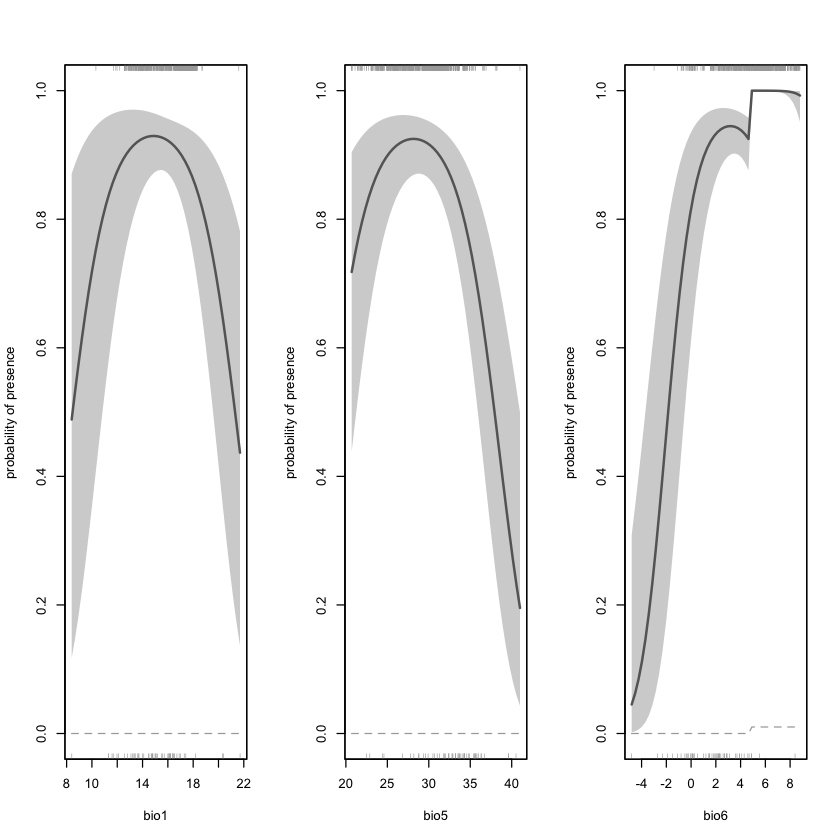

In [154]:
par(mfrow = c(1,3))
plot(ct.model, prior=T)

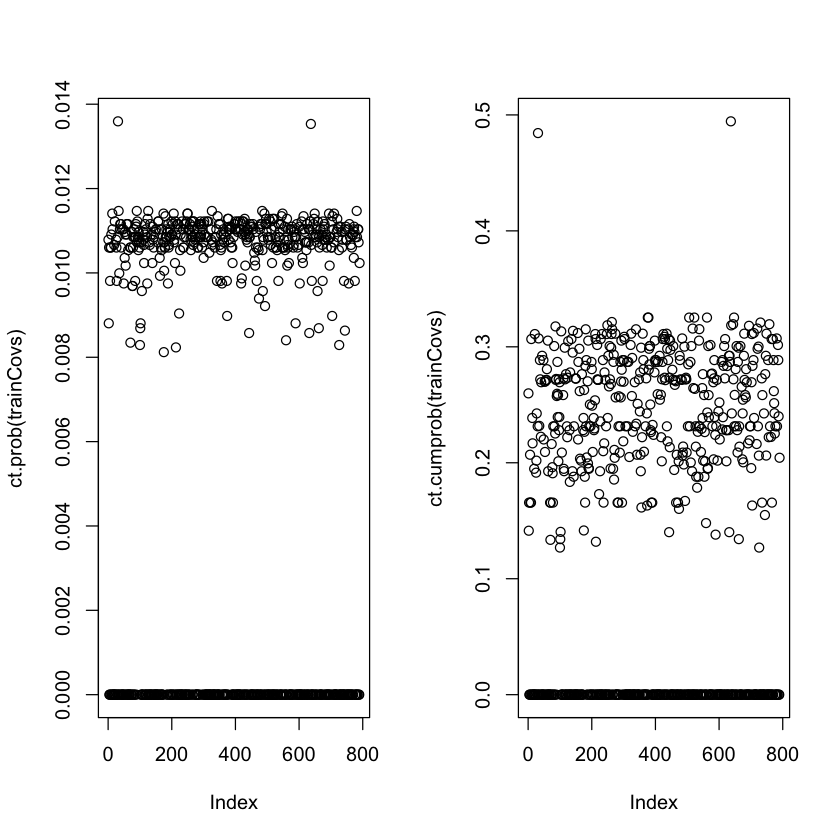

In [160]:
par(mfrow=c(1,2))
plot(ct.prob(trainCovs))
plot(ct.cumprob(trainCovs))

In [161]:
ct.cprob.model = graf(trainPres, trainCovs, prior=ct.cumprob, opt.l=T)

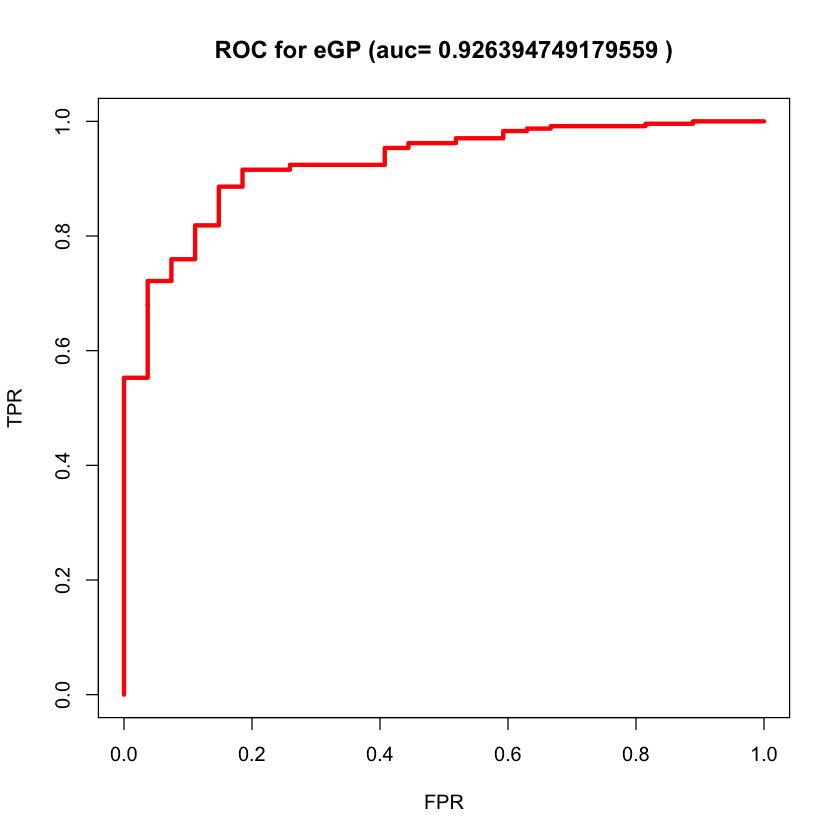

In [162]:
csimplePred = data.frame(predict(ct.cprob.model, testCovs))
prob = csimplePred$posterior.mode
pred = prediction(prob, testPres)
perf = performance(pred, measure='tpr', x.measure='fpr')
auc  = performance(pred, measure='auc')
auc = auc@y.values[[1]]
roc.data <- data.frame(fpr=unlist(perf@x.values),
                       tpr=unlist(perf@y.values),
                       model="GP")
plot(roc.data$fpr,roc.data$tpr,type="l",col="red",ylab="TPR",xlab="FPR",main=paste("ROC for eGP (auc=",auc,")"),lwd=3.5)
p = recordPlot()

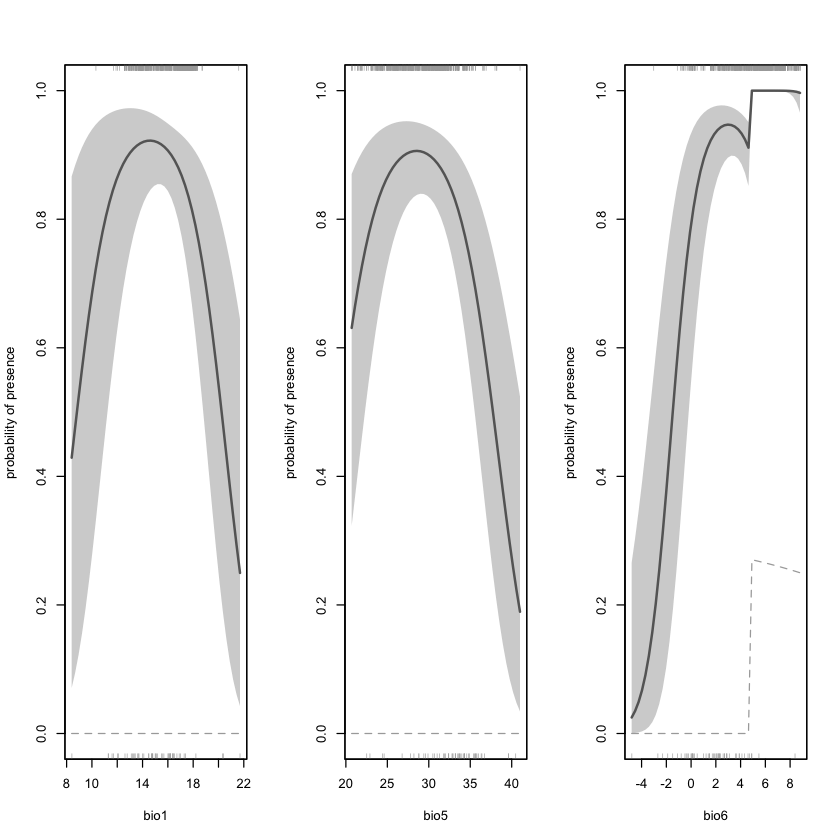

In [164]:
par(mfrow = c(1,3))
plot(ct.cprob.model, prior=T)

In [165]:
?pnorm

In [167]:
?maxent

In [186]:
head(clim_PresAbs)

presence,lon,lat,bio1,bio2,bio3,bio4,bio5,bio6,bio7,⋯,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
1,-118.3144,33.73874,175,100,52,3176,275,84,191,⋯,219,139,345,73,0,93,193,4,9,193
1,-118.3155,33.73856,175,100,52,3176,275,84,191,⋯,219,139,345,73,0,93,193,4,9,193
1,-122.0371,37.82916,145,123,51,4299,279,38,241,⋯,201,91,556,113,1,85,288,7,11,288
1,-118.3829,33.80051,175,100,53,3034,271,85,186,⋯,217,140,338,74,0,94,195,3,9,191
1,-118.4061,33.74694,174,97,53,3011,269,87,182,⋯,216,140,329,71,0,93,186,3,9,185
1,-121.9579,37.43620,153,117,53,3846,268,48,220,⋯,200,102,344,71,1,85,178,5,8,178


In [197]:
me_pres = clim_PresAbs[clim_PresAbs$presence==1]

ERROR: Error in `[.data.frame`(clim_PresAbs, clim_PresAbs$presence == 1): undefined columns selected


In [254]:
me_pres = clim_PresAbs[clim_PresAbs$presence==1,2:3]
me_abs = clim_PresAbs[clim_PresAbs$presence==0,2:3]
me = maxent(trainCovs , p=trainPres)

mePred = data.frame(predict(me, testCovs))
pred = prediction(mePred, testPres)
auc  = performance(pred, measure='auc')
auc = auc@y.values[[1]]
auc


[1] 0.9126426

[1] "graf"

In [273]:
inter = list("20")
for (mod in list(ct.cprob.model, simple, me)){
    inter =c(inter, 2)
}
inter


[[1]]
[1] "20"

[[2]]
[1] 2

[[3]]
[1] 2

[[4]]
[1] 2

In [221]:
covs[,c("bio1", "bio5", "bio6")]

,bio1,bio5,bio6
1,17.5,27.5,8.4
2,17.5,27.5,8.4
3,14.5,27.9,3.8
4,17.5,27.1,8.5
5,17.4,26.9,8.7
6,15.3,26.8,4.8
8,14.7,27.6,3.7
9,17.9,31.8,5.5
10,17.7,30.3,6.3
11,16.9,25.4,7.3
